In [ ]:
#import libraries
import numpy as np
import pandas as pd

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#Loading the avaiable data set
data_biomass = pd.read_csv('/content/drive/MyDrive/dataset/Biomass_History.csv')
data_dist = pd.read_csv('/content/drive/MyDrive/dataset/Distance_Matrix.csv')

In [ ]:
def get_biomass_df(file_path):
    df_biomass=pd.read_csv(file_path)
    df_biomass["flag"]=0
    df_biomass.loc[df_biomass["2013"]==df_biomass["2014"],"flag"]=1

    for row in df_biomass.itertuples():
        if row.flag==1:
            df_biomass.loc[row.Index,"2010"]=np.nan
            df_biomass.loc[row.Index,"2011"]=row._4
            df_biomass.loc[row.Index,"2012"]=row._5
            df_biomass.loc[row.Index,"2013"]=np.nan

    df_biomass=df_biomass.drop(columns=["flag"])
    df_biomass=df_biomass.melt(id_vars=["Index","Longitude","Latitude"],var_name="year",value_name="biomass")
    df_biomass["biomass"]=df_biomass.groupby(["Index"])["biomass"].transform(lambda x:x.interpolate().fillna(method="bfill"))
    df_biomass=pd.pivot(df_biomass,index=["Index","Longitude","Latitude"],columns=["year"])

    df_biomass.columns=[c[1] for c in df_biomass.columns]


    return df_biomass.reset_index()

In [ ]:
df_biomass = get_biomass_df('/content/drive/MyDrive/dataset/Biomass_History.csv')

In [ ]:
df_biomass.head()

,Index,Longitude,Latitude,2010,2011,2012,2013,2014,2015,2016,2017
0,0,71.33144,24.66818,8.475744,8.868568,9.202181,6.023070,10.788374,6.647325,7.387925,5.180296
1,1,71.41106,24.66818,24.029778,28.551348,25.866415,21.634459,34.419411,27.361908,40.431847,42.126945
2,2,71.49069,24.66818,44.831635,66.111168,56.982258,53.003735,70.917908,42.517117,59.181629,73.203232
3,3,71.57031,24.66818,59.974419,80.821304,78.956543,63.160561,93.513924,70.203171,74.536720,101.067352
4,4,71.64994,24.66818,14.653370,19.327524,21.928144,17.899586,19.534035,19.165791,16.531315,26.086885


In [ ]:
def create_map(file_path):

    #read shapefile as df
    shapefile = gpd.read_file(file_path)

    shapefile=shapefile[shapefile["statename"]=="Gujarat"]

    shapefile=shapefile.replace({'distname': {"Batod":"Botad",'Aravali':'Aravalli','Sabar Kantha':'Sabar kantha',
                                            'Gir Somnath':'Gir somnath','Devbhumi Dwarka':'Devbhumi dwarka',
                                            'Banas Kantha':'Banas kantha','Panch Mahals':'Panch mahals',
                                            'Chhota Udaipur':'Chhotaudepur',"The Dangs":"Dang"}})


    #assign each index to a district

    df=df_biomass.copy()

    for row1 in df.itertuples():
        offset=0.03
        longitude=row1.Longitude
        latitude=row1.Latitude
        point_b_left = geometry.Point(longitude-offset, latitude-offset)
        point_t_right = geometry.Point(longitude+offset, latitude+offset)
        point_t_left = geometry.Point(longitude-offset, latitude+offset)
        point_b_right = geometry.Point(longitude+offset, latitude-offset)

        for row2 in shapefile.itertuples():
            polygon=row2.geometry
            if polygon.contains(point_b_left) and polygon.contains(point_t_right) and polygon.contains(point_t_left) and polygon.contains(point_b_right):
                df.loc[row1.Index,"distname"]=row2.distname
                break

    print(df.distname.isna().sum()," not assigned to a district")

    return df

In [ ]:
def add_biomass_prod(df_map,df_biomass):
    df_sum=pd.DataFrame()
    drop_cols=["2010","2011","2012","2013","2014","2015","2016","2017"]
    df=df_map.copy()
    df=df.drop(columns=drop_cols)

    for y in range(2010,2020):
        df["year"]=y
        try:
            df["biomass"]=df_biomass[str(y)]
        except:
            df["biomass"]=0
        df_sum=pd.concat([df_sum,df])

    print("final shape:",df.shape)
    return df_sum

In [ ]:
def post_process_districts(df):
    df_corr = df.groupby(["distname", "year"])["biomass"].sum().reset_index()
    df_corr = pd.pivot_table(df_corr, values='biomass', index='year', columns='distname')

    for g, group in df.groupby("Index"):
        group_corr = df_corr.corrwith(group.set_index('year')['biomass'])
        sorted_corr = group_corr.sort_values(ascending=False)
        district_to_assign = sorted_corr.index[-2] if len(sorted_corr) >= 2 else None

        if district_to_assign:
            df.loc[df["Index"] == g, "distname"] = district_to_assign

    print(df.distname.isna().sum(), "not assigned to a district")

    df.plot(kind="scatter", x="Longitude", y="Latitude", c=df.distname.astype("category").cat.codes, cmap="rainbow")

    return df
# def post_process_ditricts(df):
#     for t in range(5):
#         for i in range(5):
#             for row in df.itertuples():
#                 if pd.isnull(row.distname):


#                     longitude=row.Longitude
#                     latitude=row.Latitude
#                     input=[longitude,latitude]



#                     df_closest=df.iloc[(df[['Longitude',"Latitude"]]-input).abs().mean(axis=1).sort_values().index[1+t]]

#                     if not pd.isnull(df_closest.distname):
#                         df.loc[row.Index,"distname"]=df_closest.distname

#     print(df.distname.isna().sum()," not assigned to a district")

#     return df


In [ ]:
from matplotlib import pyplot
import geopandas as gpd
from shapely import geometry

800  not assigned to a district
final shape: (2418, 6)
0 not assigned to a district


,Index,Longitude,Latitude,distname,year,biomass
0,0,71.33144,24.66818,Amreli,2010,8.475744
1,1,71.41106,24.66818,Rajkot,2010,24.029778
2,2,71.49069,24.66818,Dang,2010,44.831635
3,3,71.57031,24.66818,Junagadh,2010,59.974419
4,4,71.64994,24.66818,Amreli,2010,14.653370


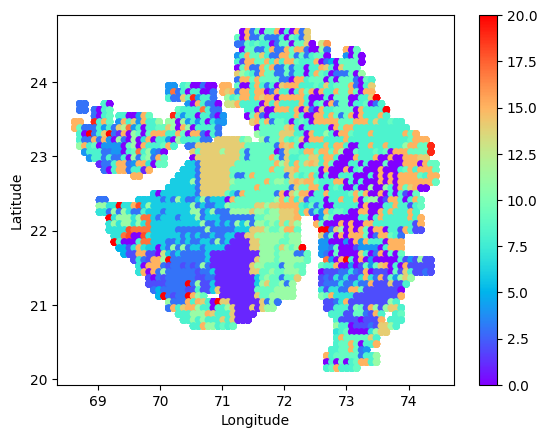

In [ ]:
df_map= create_map('/content/drive/MyDrive/dataset/districts/output.shp')
df_map= add_biomass_prod(df_map,df_biomass)
df_map= post_process_districts(df_map)
df_map.head()

In [ ]:
import os

keep_crop=["Sugarcane",
       'Bajra', 'Castor seed',
       'Cotton(lint)', 'Arhar/Tur',
        'Gram', 'Groundnut',
        'Jowar', 'Maize',
       'Moong(Green Gram)',
         'Rapeseed &Mustard',
       'Rice', 'Sesamum',
       'Soyabean',  'Tobacco',
       'Wheat']

sum_districts=[["Aravalli",'Sabar kantha'],
    ["Botad",'Ahmadabad','Bhavnagar'],
    ['Chhotaudepur','Vadodara'],
    ['Kheda','Mahisagar','Panch mahals'],
    ['Morbi','Rajkot','Surendranagar','Jamnagar',"Devbhumi dwarka"],
    ['Gir somnath','Junagadh'] ]

def process_df(df):
    df_s=df.copy()

    crop_name=df_s.columns[0][0][6:]


    df_s.columns=[c[1]+"_"+c[2] for c in df_s.columns ]
    df_s=df_s[df_s["State_State"]=="Gujarat"]

    df_s=df_s.melt(id_vars=['S.No._S.No.', 'State_State', 'District_District'])
    df_s["year"]=df_s["variable"].str[:4].astype("int")
    df_s["crop"]=crop_name
    df_s=df_s.drop(columns=['S.No._S.No.', 'State_State', 'variable'])
    df_s.columns=["distname","production","year","crop_type"]
    return df_s

def generate_crop_df(root_folder):
    df_all = pd.DataFrame()

    for f in os.listdir(root_folder):
        try:
            # Specify encoding parameter when reading HTML file
            df_raw = pd.read_html(root_folder + f, encoding='ISO-8859-1')
            df = process_df(df_raw[0])

            df_all = pd.concat([df_all, df])
        except UnicodeDecodeError as e:
            print(f"Error reading file {f}: {e}")

    df_pivot = pd.pivot(df_all, columns=["crop_type", "distname"], index=["year"])
    df_pivot.columns = [str(c[1]) + "-" + str(c[2]) for c in df_pivot.columns.to_flat_index()]

    return df_pivot


def filter_crop(df):

    return df[[c for c in df.columns if c.split("-")[0] in keep_crop]]


"""
def impute_dataset(df):
    return df.fillna(0)

"""
def impute_dataset(df):

    district_to_impute = [item for sublist in sum_districts for item in sublist]
    df_impute=df[[c for c in df.columns if c.split("-")[1] in district_to_impute]].copy()

    for crop in keep_crop:
        for s in sum_districts:
            relevant_cols=[crop+"-"+c for c in s ]

            for col in relevant_cols:
                if col not in df_impute.columns:
                    df_impute.loc[:,col]=0
            df_impute.loc[:,"sum_"+s[0]+"-"+s[1]+"-"+crop]=df_impute[relevant_cols].sum(axis=1)

    X_train=df_impute[(df_impute.index>2013)]
    X_pred=df_impute[df_impute.index<2014]

    for crop in keep_crop:
        for s in sum_districts:
            for district in s:
                share=(X_train[crop+"-"+district]/X_train["sum_"+s[0]+"-"+s[1]+"-"+crop]).mean()
                X_pred.loc[:,crop+"-"+district]=share*X_pred["sum_"+s[0]+"-"+s[1]+"-"+crop]

    df_reconstructed=pd.concat([X_train,X_pred]).sort_index()

    for c in df_reconstructed.columns:
        if "sum" in c:continue
        df.loc[:,c]=df_reconstructed.loc[:,c]

    return df



def unpivot(df_crop):
    df=df_crop.reset_index().melt(id_vars=["year"],value_name="production")
    df["distname"]=df["variable"].str.split("-").str[1]
    df["crop_type"]=df["variable"].str.split("-").str[0]
    df=df.drop(columns=["variable"])

    print("final shape:",df.shape)

    return df

In [ ]:
root_folder="/content/drive/MyDrive/dataset/desagri_all/"
df_crop=generate_crop_df(root_folder)
df_crop=filter_crop(df_crop)
df_crop=impute_dataset(df_crop)
df_crop=unpivot(df_crop)
df_crop.head(10)

<ipython-input-12-77e579198cf9>:78: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_impute.loc[:,"sum_"+s[0]+"-"+s[1]+"-"+crop]=df_impute[relevant_cols].sum(axis=1)
<ipython-input-12-77e579198cf9>:77: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_impute.loc[:,col]=0
<ipython-input-12-77e579198cf9>:77: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a d

final shape: (5456, 4)


,year,production,distname,crop_type
0,2010,185700.0,Banas kantha,Castor seed
1,2011,367000.0,Banas kantha,Castor seed
2,2012,308200.0,Banas kantha,Castor seed
3,2013,277156.0,Banas kantha,Castor seed
4,2014,358576.0,Banas kantha,Castor seed
5,2015,263781.0,Banas kantha,Castor seed
6,2016,220067.0,Banas kantha,Castor seed
7,2017,360909.0,Banas kantha,Castor seed
8,2018,172216.0,Banas kantha,Castor seed
9,2019,223575.0,Banas kantha,Castor seed


In [ ]:
df_elev=pd.read_csv("/content/drive/MyDrive/dataset/wc2.1_30s_elev.csv").rename({"mean":"elevation"},axis=1).fillna(0) #some nan values on the borders
df_elev.head()

,min,max,count,elevation,year,month,type,index,lat,long
0,8.0,13.0,100,11.010000,0s_e,ev,2.1_,0,24.66818,71.33144
1,12.0,28.0,90,15.377778,0s_e,ev,2.1_,1,24.66818,71.41106
2,15.0,37.0,100,24.220000,0s_e,ev,2.1_,2,24.66818,71.49069
3,24.0,46.0,90,33.200000,0s_e,ev,2.1_,3,24.66818,71.57031
4,30.0,53.0,100,43.340000,0s_e,ev,2.1_,4,24.66818,71.64994


In [ ]:
df_cropland=pd.read_csv("/content/drive/MyDrive/dataset/Global_cropland_3km_2019.csv").rename({"mean":"cropland"},axis=1).fillna(0) #some nan values on the borders
df_cropland.head()

,min,max,count,cropland,majority,median,std,sum,minority,range,year,month,type,index,biomass,lat,long
0,0.0,13.0,9,4.555556,0.0,2.0,5.057692,41.0,2.0,13.0,tif,0.0,al_c,0,5.180296,24.66818,71.33144
1,8.0,90.0,9,30.000000,11.0,20.0,25.542992,270.0,8.0,82.0,tif,0.0,al_c,1,42.126945,24.66818,71.41106
2,29.0,92.0,9,74.000000,29.0,79.0,18.938497,666.0,29.0,63.0,tif,0.0,al_c,2,73.203232,24.66818,71.49069
3,79.0,93.0,9,86.111111,81.0,85.0,4.931631,775.0,79.0,14.0,tif,0.0,al_c,3,101.067352,24.66818,71.57031
4,79.0,99.0,12,88.000000,81.0,88.0,6.258328,1056.0,79.0,20.0,tif,0.0,al_c,4,26.086885,24.66818,71.64994


In [ ]:
def create_final_dataset(df_map,df_crop,df_elev,df_cropland):

    df_merged=df_map.merge(df_crop,left_on=["distname","year"],right_on=["distname","year"],how="left")
    df_merged=df_merged.merge(df_elev[["index","elevation"]],left_on=["Index"],right_on=["index"],how="left").drop(columns=["index"])
    df_merged=df_merged.merge(df_cropland[["index","cropland"]],left_on=["Index"],right_on=["index"],how="left").drop(columns=["index"])


    df_pivot=pd.pivot_table(df_merged,columns=["crop_type"],index=["Index","Longitude","Latitude","distname","biomass","year","elevation","cropland"])
    df_pivot.columns = [ c[0]+"-"+str(c[1]) for c in df_pivot.columns.to_flat_index()]
    df_pivot=df_pivot.reset_index()

    df_pivot=df_pivot.fillna(0) #Nan means no prod

    print("final shape:",df_pivot.shape)

    return df_pivot

def add_features(df):

    cat_dict=dict( enumerate(df["distname"].astype("category").cat.categories ) )
    df["distname"]=df["distname"].astype("category").cat.codes


    print(cat_dict)

    for c in df.distname.unique():
        df["in_district_"+str(c)]=np.where(df["distname"]==c,1,0)


    df["total_crop_prod"]=df[[c for c in df.columns if "production" in c]].sum(axis=1)
    df["count_district"]=df.groupby(["distname"])["total_crop_prod"].transform(lambda x:x.count())

    df["index_cotton_prod_share"]=df["production-Cotton(lint)"]/df["count_district"]

    for c in ["production-Cotton(lint)"]:

        df["district_prod_"+c+"_sum"]=df.groupby(["distname","year"])[c].transform(lambda x:x.sum())

    df["log_biomass"]=np.log10(df["biomass"]+1e-5)

    return df

In [ ]:
df_final=create_final_dataset(df_map,df_crop,df_elev,df_cropland)
df_final=add_features(df_final)

df_final.head()

final shape: (24180, 24)
{0: 'Amreli', 1: 'Anand', 2: 'Botad', 3: 'Dang', 4: 'Devbhumi dwarka', 5: 'Dohad', 6: 'Gandhinagar', 7: 'Gir somnath', 8: 'Jamnagar', 9: 'Junagadh', 10: 'Kachchh', 11: 'Narmada', 12: 'Panch mahals', 13: 'Patan', 14: 'Porbandar', 15: 'Rajkot', 16: 'Sabar kantha', 17: 'Surat', 18: 'Surendranagar', 19: 'Tapi', 20: 'Valsad'}


,Index,Longitude,Latitude,distname,biomass,year,elevation,cropland,production-Arhar/Tur,production-Bajra,...,in_district_12,in_district_1,in_district_6,in_district_18,in_district_10,total_crop_prod,count_district,index_cotton_prod_share,district_prod_production-Cotton(lint)_sum,log_biomass
0,0,71.33144,24.66818,0,0.000000,2018,11.01,4.555556,2454.0,5768.0,...,0,0,0,0,0,666889.0,2690,205.437918,148656932.0,-5.000000
1,0,71.33144,24.66818,0,0.000000,2019,11.01,4.555556,3068.0,16393.0,...,0,0,0,0,0,1991530.0,2690,545.349071,394620041.0,-5.000000
2,0,71.33144,24.66818,0,5.180296,2017,11.01,4.555556,2642.0,7953.0,...,0,0,0,0,0,1095213.0,2690,310.411524,224616883.0,0.714355
3,0,71.33144,24.66818,0,6.023070,2013,11.01,4.555556,1057.0,10030.0,...,0,0,0,0,0,2458662.0,2690,711.905948,515142263.0,0.779819
4,0,71.33144,24.66818,0,6.647325,2015,11.01,4.555556,912.0,6399.0,...,0,0,0,0,0,1323761.0,2690,394.115985,285186268.0,0.822648


In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MaxAbsScaler,StandardScaler,MinMaxScaler,RobustScaler,PowerTransformer
from sklearn.ensemble import RandomForestRegressor,GradientBoostingRegressor,ExtraTreesRegressor,AdaBoostRegressor,RandomForestClassifier,StackingRegressor,VotingRegressor
from sklearn.metrics import mean_absolute_error,auc,roc_curve
from sklearn.linear_model import LinearRegression,ElasticNet,Lasso
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsRegressor

In [ ]:
def train_model_log(df):


    params = {
        'random_state': 42,
            "n_estimators":100,
    }

    pipeline = Pipeline([
        ('scaler', StandardScaler()),
        ('regressor', ExtraTreesRegressor(**params))
    ])

    results=pd.DataFrame()
    tot_mae=[]
    for y in [2010,2011,2012,2013,2014,2015,2016,2017]:

        df_train=df.loc[(~df.year.isin([2018,2019,y]))&(df["biomass"]),:]
        df_test=df.loc[df.year==y,:]

        X_train=df_train.drop(columns=["log_biomass","biomass","year"])
        y_train=df_train[["log_biomass"]].values.ravel()

        X_test=df_test.drop(columns=["log_biomass","biomass","year"])
        y_test=df_test[["log_biomass"]].values.ravel()

        pipeline.fit(X_train,y_train)

        mae_test=np.abs(10**pipeline.predict(X_test)-10**y_test).mean()
        mae_train=np.abs(10**pipeline.predict(X_train)-10**y_train).mean()
        tot_mae+=[(y,mae_train,mae_test)]
        print(y,mae_train,mae_test)


        df_test.loc[:,"pred"]=10**pipeline.predict(X_test)
        df_test.loc[:,"mae"]=10**y_test-10**pipeline.predict(X_test)
        results=pd.concat([results,df_test])



    sum_df=pd.DataFrame(tot_mae,columns=["year","mae_train","mae_test"]).T
    sum_df["mean"]=sum_df.mean(axis=1)

    print(sum_df)

    return pipeline,results


def generate_predictions(model,df,filename):

    df_train=df.loc[~df.year.isin([2018,2019]),:]

    X_train=df_train.drop(columns=["log_biomass","year","biomass"])
    y_train=df_train[["log_biomass"]].values.ravel()


    model.fit(X_train,y_train)

    X_2018=df[df.year==2018].drop(columns=["log_biomass","year","biomass"])
    X_2019=df[df.year==2019].drop(columns=["log_biomass","year","biomass"])

    y_2018=10**model.predict(X_2018)
    y_2019=10**model.predict(X_2019)

    fig,ax=plt.subplots(1,2,figsize=(20,10))
    X_2018["2018"]=y_2018

    X_2018.plot(kind="scatter",x="Longitude",y="Latitude",c="2018",cmap="rainbow",ax=ax[0],title="2018 forecast: "+str(int(np.sum(y_2018))))

    X_2019["2019"]=y_2019
    X_2019.plot(kind="scatter",x="Longitude",y="Latitude",c="2019",cmap="rainbow",ax=ax[1],title="2019 forecast: "+str(int(np.sum(y_2019))))

    pd.concat([X_2018["2018"].reset_index(),X_2019["2019"].reset_index()],axis=1).drop(columns="index").to_csv(f"/content/{filename}")


    return y_2018,y_2019


def add_theo_biomass(df,val_year=None):

    if "theo_biomass" in df.columns:
        df=df.drop(columns=["theo_biomass"])

    params = {
        'random_state': 42,
            "criterion": "log_loss",
            "class_weight":"balanced",
            "n_estimators":100,
    }

    pipeline = LinearRegression()

    prediction_columns = ["production-Cotton(lint)"]


    if val_year is None:
        tot_mae=[]
        for y in [2010,2011,2012,2013,2014,2015,2016,2017]:
            #if y!=2012:continue

            df_train=df.loc[~df.year.isin([2018,2019,y]),:]
            df_test=df.loc[df.year==y,:]

            X_train=df_train[prediction_columns]
            y_train=df_train["biomass"].values.ravel()

            X_test=df_test[prediction_columns]
            y_test=df_test["biomass"].values.ravel()

            pipeline.fit(X_train,y_train)

            mae_test=np.abs(pipeline.predict(X_test)-y_test).mean()
            mae_train=np.abs(pipeline.predict(X_train)-y_train).mean()
            tot_mae+=[(y,mae_train,mae_test)]
            print(y,mae_train,mae_test)




        sum_df=pd.DataFrame(tot_mae,columns=["year","auc_test"]).T
        sum_df["mean"]=sum_df.mean(axis=1)

        print(sum_df)

        df_train=df.loc[~df.year.isin([2018,2019]),:]

        X_train=df_train[prediction_columns]
        y_train=df_train["biomass"].values.ravel()


        pipeline.fit(X_train,y_train)

        df["theo_biomass"]=np.where(df.year.isin([2018,2019]),pipeline.predict(df[prediction_columns]),df["biomass"])


    else:
        df_train=df.loc[~df.year.isin([2018,2019,val_year]),:]

        X_train=df_train[prediction_columns]
        y_train=df_train["biomass"].values.ravel()


        pipeline.fit(X_train,y_train)

        df["theo_biomass"]=np.where(df.year.isin([2018,2019,val_year]),pipeline.predict(df[prediction_columns]),df["biomass"])

    return df

In [ ]:
pipeline,results= train_model_log(df_final)

2010 9.876375056957633e-13 32.798033595825935


<ipython-input-19-19b99aa5793a>:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test.loc[:,"pred"]=10**pipeline.predict(X_test)
<ipython-input-19-19b99aa5793a>:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test.loc[:,"mae"]=10**y_test-10**pipeline.predict(X_test)


2011 9.77392789533413e-13 37.45323902662634


<ipython-input-19-19b99aa5793a>:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test.loc[:,"pred"]=10**pipeline.predict(X_test)
<ipython-input-19-19b99aa5793a>:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test.loc[:,"mae"]=10**y_test-10**pipeline.predict(X_test)


2012 1.027513727002525e-12 53.030478796305125


<ipython-input-19-19b99aa5793a>:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test.loc[:,"pred"]=10**pipeline.predict(X_test)
<ipython-input-19-19b99aa5793a>:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test.loc[:,"mae"]=10**y_test-10**pipeline.predict(X_test)


2013 9.719131065189042e-13 45.2160295980309


<ipython-input-19-19b99aa5793a>:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test.loc[:,"pred"]=10**pipeline.predict(X_test)
<ipython-input-19-19b99aa5793a>:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test.loc[:,"mae"]=10**y_test-10**pipeline.predict(X_test)


2014 9.66118975609051e-13 33.867734158593066


<ipython-input-19-19b99aa5793a>:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test.loc[:,"pred"]=10**pipeline.predict(X_test)
<ipython-input-19-19b99aa5793a>:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test.loc[:,"mae"]=10**y_test-10**pipeline.predict(X_test)


2015 9.97907189865615e-13 29.738961172218662


<ipython-input-19-19b99aa5793a>:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test.loc[:,"pred"]=10**pipeline.predict(X_test)
<ipython-input-19-19b99aa5793a>:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test.loc[:,"mae"]=10**y_test-10**pipeline.predict(X_test)


2016 1.0168815222843148e-12 44.77475599406074


<ipython-input-19-19b99aa5793a>:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test.loc[:,"pred"]=10**pipeline.predict(X_test)
<ipython-input-19-19b99aa5793a>:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test.loc[:,"mae"]=10**y_test-10**pipeline.predict(X_test)


2017 9.689845610023218e-13 51.24655340208566
                      0             1             2             3  \
year       2.010000e+03  2.011000e+03  2.012000e+03  2.013000e+03   
mae_train  9.876375e-13  9.773928e-13  1.027514e-12  9.719131e-13   
mae_test   3.279803e+01  3.745324e+01  5.303048e+01  4.521603e+01   

                      4             5             6             7  \
year       2.014000e+03  2.015000e+03  2.016000e+03  2.017000e+03   
mae_train  9.661190e-13  9.979072e-13  1.016882e-12  9.689846e-13   
mae_test   3.386773e+01  2.973896e+01  4.477476e+01  5.124655e+01   

                   mean  
year       2.013500e+03  
mae_train  9.892937e-13  
mae_test   4.101572e+01  


<ipython-input-19-19b99aa5793a>:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test.loc[:,"pred"]=10**pipeline.predict(X_test)
<ipython-input-19-19b99aa5793a>:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test.loc[:,"mae"]=10**y_test-10**pipeline.predict(X_test)


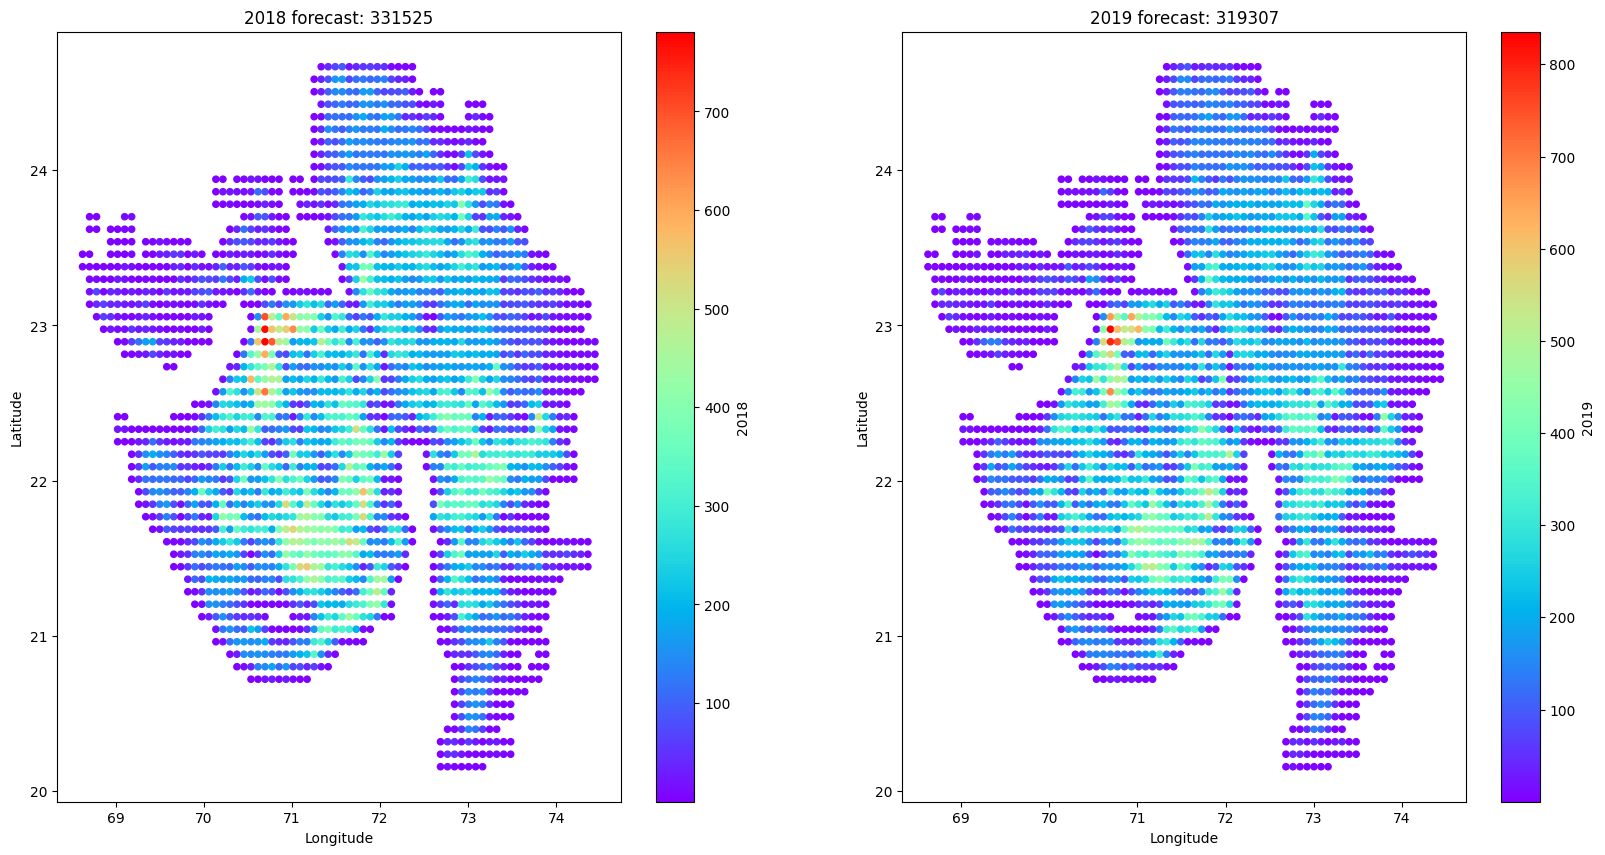

In [ ]:
y_2018,y_2019= generate_predictions(pipeline,df_final,"forecast_extratrees.csv")

In [ ]:
features_imp=[(i,j) for i,j in zip(df_final.drop(columns=["log_biomass","biomass","year"]).columns,pipeline.steps[1][1].feature_importances_)]

sorted(features_imp, key=lambda x: x[1], reverse=True)

[('cropland', 0.5291118579247905),
 ('Longitude', 0.10639608530268033),
 ('elevation', 0.09265998665435712),
 ('Index', 0.05827781166414499),
 ('Latitude', 0.05537794323103465),
 ('in_district_19', 0.011054366454827054),
 ('in_district_14', 0.010484008719350827),
 ('count_district', 0.010450325574710751),
 ('distname', 0.008507660567497155),
 ('in_district_8', 0.008125849729589579),
 ('in_district_12', 0.007979567591058292),
 ('in_district_0', 0.00773427458354729),
 ('in_district_15', 0.0075301199809372985),
 ('production-Rice', 0.006139697542220902),
 ('in_district_9', 0.005664339561498093),
 ('in_district_3', 0.005285604407082418),
 ('in_district_7', 0.005130280432866181),
 ('in_district_2', 0.004679126155817426),
 ('production-Castor seed', 0.004563464855554836),
 ('in_district_11', 0.00451415135646413),
 ('production-Arhar/Tur', 0.0034484393596574416),
 ('production-Sesamum', 0.003284347480940654),
 ('production-Soyabean', 0.0032711608438188164),
 ('production-Rapeseed &Mustard', 0

In [ ]:
forecast=pd.read_csv("/content/forecast_extratrees.csv")
true=pd.read_csv("/content/drive/MyDrive/dataset/Biomass_private_databasea91704d.csv")

In [ ]:
forecast_score_2018,forecast_score_2019=np.mean(np.abs(forecast["2018"]-true["2018"])),np.mean(np.abs(forecast["2019"]-true["2019"]))
forecast_score_2018,forecast_score_2019

(33.17616849985103, 44.05402424906224)

In [ ]:
def get_score(forecast_cost,opt_cost):
    return 100-((forecast_cost*2418)+opt_cost)*80/500000
get_score(forecast_score_2018,44150),get_score(forecast_score_2019,26786)

(80.10080393077763, 78.6706190985228)

##Arima Model

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
<ipython-input-37-4124ca9fd6d3>:32: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  forecast[i,0] = yhat
<ipython-input-37-4124ca9fd6d3>:43: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  forecast[i,1] = yhat2
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-in

[[3191484.07638784 3256102.23533369]
 [8671931.66111503 8653586.52152622]
 [4934317.27450528 4923896.3638565 ]
 ...
 [ 844256.58875661  842001.49833015]
 [1164582.57747223 1160629.71611838]
 [ 598838.5620479   597002.17004057]]


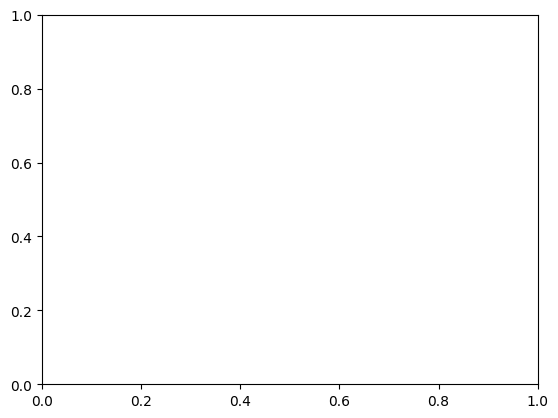

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA

YEARS = [2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017]

# Read in the data
df = df_final.copy()

#print(df.tail())

# Convert to numpy array
array = df.to_numpy()

# Create a figure with subplots
fig, plt1 = plt.subplots(nrows=1, ncols=1)

#**********PREDICTION LOOP**********
i = 0
forecast = np.zeros((len(array),2))
# loop through each co-ordinate
for co_ord in array:


    # fit model
    model = ARIMA(co_ord[3:], order=(1, 0, 1))
    model_fit = model.fit()
    # make prediction for 2018
    yhat = model_fit.predict(8,8)
    # append to forecast list
    forecast[i,0] = yhat

    # add to co-ordinate history
    co_ord = np.append(co_ord, yhat)

    # fit model again
    model = ARIMA(co_ord[3:], order=(1, 0, 1))
    model_fit = model.fit()
    # make prediction for 2019
    yhat2 = model_fit.predict(9,9)
    # append to forecast list
    forecast[i,1] = yhat2

    # print('forecasted value for index' + str(i))
    i+=1

print(forecast)
# save to csv
np.savetxt("forecast_arima.csv", forecast, delimiter=",", header='2018, 2019')


In [ ]:
forecast=pd.read_csv("/content/forecast.csv")
true=pd.read_csv("/content/drive/MyDrive/dataset/Biomass_private_databasea91704d.csv")

In [ ]:
forecast_score_2018,forecast_score_2019=np.mean(np.abs(forecast["2018"]-true["2018"])),np.mean(np.abs(forecast["2019"]-true["2019"]))
forecast_score_2018,forecast_score_2019

KeyError: '2018'

In [ ]:
def get_score(forecast_cost,opt_cost):
    return 100-((forecast_cost*2418)+opt_cost)*80/500000
get_score(forecast_score_2018,44150),get_score(forecast_score_2019,26786)

(76.55779172647728, 80.54526306371105)

##Prophet

In [ ]:
import pandas as pd
from prophet import Prophet

df = pd.read_csv('/content/drive/MyDrive/Final_Year_Project/dataset/Biomass_History.csv', header=0)
#print(df.tail())

# Convert to numpy array
array = df.to_numpy()

# Function to perform Prophet forecast
def prophet_forecast(data):
    # Create a Prophet model
    model = Prophet()

    # Prepare the dataframe
    df = pd.DataFrame()
    df['ds'] = pd.to_datetime(YEARS, format='%Y')
    df['y'] = data[3:]  # Assuming the column with values is at index 3 onwards

    # Fit the model
    model.fit(df)

    # Make future dataframe for predictions
    future = model.make_future_dataframe(periods=2, freq='Y')  # Forecasting for 2 years: 2018, 2019

    # Predict
    forecast = model.predict(future)

    # Extract the forecasted values for 2018 and 2019
    forecast_values = forecast[['ds', 'yhat']].tail(2).values[:, 1]

    return forecast_values

# Perform the prediction loop
forecast = np.zeros((len(array), 2))
for i, co_ord in enumerate(array):
    forecast[i] = prophet_forecast(co_ord)

print(forecast)

# Save to CSV
np.savetxt("forecast_prophet.csv", forecast, delimiter=",", header='2018, 2019')


Streaming output truncated to the last 5000 lines.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp4tn8adh3/vz4s5o8y.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=67290', 'data', 'file=/tmp/tmp4tn8adh3/n0lq6pu1.json', 'init=/tmp/tmp4tn8adh3/vz4s5o8y.json', 'output', 'file=/tmp/tmp4tn8adh3/prophet_model0jeqjhvc/prophet_model-20231126165240.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
16:52:40 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
16:52:40 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:n_changepoints greater than number of 

[[ 7.72419107e+00  7.66175829e+00]
 [ 4.37989286e+01  4.66810828e+01]
 [ 6.00315272e+01  6.01633151e+01]
 ...
 [ 4.37157763e-02  4.39809395e-02]
 [ 6.47306187e-01  4.23510161e-01]
 [ 2.37831164e-02 -4.16826639e-02]]


In [ ]:
forecast=pd.read_csv("/content/forecast_prophet.csv")
true=pd.read_csv("/content/drive/MyDrive/Final_Year_Project/dataset/Biomass_private_databasea91704d.csv")

In [ ]:
forecast_score_2018,forecast_score_2019=np.mean(np.abs(forecast["2018"]-true["2018"])),np.mean(np.abs(forecast["2019"]-true["2019"]))
forecast_score_2018,forecast_score_2019

(62.874881235030195, 112.85864252197022)

In [ ]:
def get_score(forecast_cost,opt_cost):
    return 100-((forecast_cost*2418)+opt_cost)*80/500000
get_score(forecast_score_2018,44150),get_score(forecast_score_2019,26786)

(68.61096594779153, 52.05148838110016)

In [ ]:
import sys

In [ ]:
!pip install pulp

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.7/17.7 MB 41.3 MB/s eta 0:00:00


In [ ]:
import pulp as pl
from pulp import LpMaximize, LpProblem, LpStatus, lpSum, LpVariable,LpMinimize,LpConstraint,lpDot,LpAffineExpression
from sklearn.cluster import KMeans
import numpy as np
import random
import pandas as pd


CAP_DEPOT=20000
CAP_RAF=100000
EPS=1e-6
df_biomass=pd.read_csv("/content/drive/MyDrive/dataset/Biomass_History.csv")

def run_substraction(dist_mat,forecast_df,index_thresh=200,raf_thresh=500,min_depot=15,max_depot=60,N_raf=3):

  top_index=forecast_df[forecast_df["biomass"]>index_thresh].index
  top_raf=[985, 1358, 1861] #forecast_df[forecast_df["biomass"]>raf_thresh].index
  cost_dict=[]

  current_depot_index=random.sample(list(top_index), max_depot)
  current_raf_index=random.sample(list(top_raf), N_raf)


  for N_depot in reversed(range(min_depot,max_depot+1)):

    #raf_index=of.get_raf_index(df_biomass,current_depot_index,N_raf)

    model=create_biomass_mat_lp_with_adjust(current_depot_index,current_raf_index,forecast_df.to_numpy(),dist_mat)

    biomass_mat,pellet_mat,adjust=get_matrices_from_lp(model,N_depot,N_raf)
    forecast_new=forecast_df.to_numpy().flatten()+adjust.flatten()
    costs=get_cost(current_depot_index,current_raf_index,biomass_mat,dist_mat,pellet_mat,forecast_new,adjust,ignore_constraints=True)

    if costs[-1] is not None:
      cost_dict+=[(current_depot_index.copy(),current_raf_index,costs[-1])]

    min_biomass=np.argmin(biomass_mat.sum(axis=0))
    del current_depot_index[min_biomass]


  df_opt=pd.DataFrame(cost_dict,columns=["depot","raf","cost"])


  return df_opt

def run_optimization(dist_mat,forecast_df,index_thresh=200,raf_thresh=500,min_depot=15,max_depot=16,N_raf=3,max_iter=1,dlong=0.05,dlat=0.05,n=1,ignore=32000):
  df_opt=run_substraction(dist_mat,forecast_df,index_thresh=index_thresh,raf_thresh=raf_thresh,min_depot=min_depot,max_depot=max_depot,N_raf=N_raf)
  best_run=df_opt.iloc[df_opt["cost"].idxmin()]

  print("best run has cost of ",best_run["cost"])
  if best_run["cost"]>ignore:
     return best_run["raf"],best_run["depot"]
  else:
    best_raf_index=best_run["raf"]
    best_depot_index=best_run["depot"]

    final_raf_index,final_depot_index=run_greedy_search(best_depot_index,best_raf_index,forecast_df.to_numpy(),dist_mat,max_iter=max_iter,dlong=dlong,dlat=dlat,n=n)

    return final_raf_index,final_depot_index




def find_new_index(index,dlat,dlong,n):
    v=df_biomass.loc[index,["Latitude","Longitude"]].values+np.array([dlat,dlong])

    index_list=np.abs(df_biomass[["Latitude","Longitude"]]-v).sort_values(["Latitude","Longitude"]).head(n+1).index.values.tolist()
    index_list=[c for c in index_list if c!=index]
    return index_list


def run_greedy_search(depot_index,raf_index,forecast,dist_mat,max_iter,dlong,dlat,n):

      init_cost=get_cost_from_lp_with_adjust(depot_index,raf_index,forecast,dist_mat)[-1]
      best_cost=init_cost

      init_dlong=dlong
      init_dlat=dlat


      for i in range(max_iter):
            found=False

            for i in range(len(raf_index)):
                  old_index=raf_index[i]
                  for new in find_new_index(raf_index[i],dlong,dlat,n):

                        raf_index[i]=new
                        new_cost=get_cost_from_lp_with_adjust(depot_index,raf_index,forecast,dist_mat)[-1]

                        if new_cost<best_cost:
                              print("new best cost found",new_cost)
                              print("new raf index is", raf_index[i])
                              best_cost=new_cost
                              dlong=init_dlong
                              dlat=init_dlat
                              print(raf_index)
                              break


                        raf_index[i]=old_index

            for i in range(len(depot_index)):
                  old_index=depot_index[i]
                  print("index",i)
                  for new in find_new_index(depot_index[i],dlong,dlat,n):

                        depot_index[i]=new
                        try:
                              new_cost=get_cost_from_lp_with_adjust(depot_index,raf_index,forecast,dist_mat)[-1]
                        except:
                              new_cost=1e9

                        if new_cost<best_cost:
                              found=True
                              print("new best cost found",new_cost)
                              print("new depot index is", depot_index[i])
                              best_cost=new_cost
                              dlong=init_dlong
                              dlat=init_dlat
                              print(depot_index)
                              break


                        depot_index[i]=old_index

            if found==False:
                  print("no improvement for all points, extending reach")
                  dlong+=0.05
                  dlat+=0.05

      return raf_index,depot_index



def create_biomass_mat_lp_with_adjust(depot_index,raf_index,forecast,dist_mat):

  forecast=np.around(forecast,4)
  dist_mat_biomass=dist_mat[:,depot_index]
  dist_mat_pellet=dist_mat[depot_index,:][:,raf_index]
  model = LpProblem(name="biomass-allocation", sense=LpMinimize)
  I = range(2418)
  J = range(len(depot_index))
  K= range(len(raf_index))


  # Define the decision variables
  x = LpVariable.dicts("biomass matrix",((i,j)for i in I for j in J),cat="Continuous",lowBound=0)
  y = LpVariable.dicts("pellet matrix",((j,k)for j in J for k in K),cat="Continuous",lowBound=0)
  d = [LpVariable(f"forecast_adjust_var_{i}") for i in I]
  d_abs = [LpVariable(f"forecast_abs_adjust_var_{i}",lowBound=0) for i in I]

  # Add constraints
  model += (lpSum(y[j,k] for j in J for k in K) >= lpSum(forecast[i]+d[i] for i in I)*0.8,"min biomass prod")

  for k in K:
    model += (lpSum(y[j,k] for j in J)<=CAP_RAF-1e-3,"max pellet prod "+str(k))

  for j in J:
    model += (lpSum(x[i,j] for i in I)<=CAP_DEPOT-1e-3,"max depot prod "+str(j))

  for i in I:
    model += ( lpSum(x[i,j] for j in J) <= forecast[i]+ d[i]-1e-4,"max biomass extracted "+str(i))

  for j in J:
    model += ((lpSum(y[j,k] for k in K) - lpSum(x[i,j] for i in I)) <= 1e-4,"max biomass extracted pellet 1 "+str(j))
    model += ((lpSum(x[i,j] for i in I)-lpSum(y[j,k] for k in K)) <= 1e-4,"max biomass extracted pellet 2 "+str(j))

  for i in I:
    model += (d_abs[i]>=d[i],"abs constraint plus_"+str(i))
    model += (d_abs[i]>=-d[i],"abs constraint minus_"+str(i))


  # Set objective

  model += LpAffineExpression([(x[i,j],dist_mat_biomass[i,j]) for i in I for j in J])*0.001+LpAffineExpression([(y[j,k],dist_mat_pellet[j,k]) for j in J for k in K])*0.001+lpSum(CAP_DEPOT-lpSum(x[i,j] for i in I) for j in J)+lpSum(CAP_RAF-lpSum(y[j,k] for j in J) for k in K)+LpAffineExpression([(d_abs[i],1) for i in I])


  # Solve the optimization problem
  status = model.solve(pl.PULP_CBC_CMD(gapRel=0.01))

  print(f"status: {model.status}, {LpStatus[model.status]}")
  print(f"objective: {model.objective.value()}")

  #for var in model.variables():
  #  print(f"{var.name}: {var.value()}")

  #for name, constraint in model.constraints.items():
  #  if "min biomass prod" in name:
  #    print(f"{name}: {constraint.value()}")

  return model

def create_biomass_mat_lp(depot_index,raf_index,forecast,dist_mat):

  forecast=np.around(forecast,4)
  dist_mat_biomass=dist_mat[:,depot_index]
  dist_mat_pellet=dist_mat[depot_index,:][:,raf_index]
  model = LpProblem(name="biomass-allocation", sense=LpMinimize)
  I = range(2418)
  J = range(len(depot_index))
  K= range(len(raf_index))


  # Define the decision variables
  x = LpVariable.dicts("biomass matrix",((i,j)for i in I for j in J),cat="Continuous",lowBound=0)
  y = LpVariable.dicts("pellet matrix",((j,k)for j in J for k in K),cat="Continuous",lowBound=0)


  # Add constraints
  model += (lpSum(y[j,k] for j in J for k in K) >= lpSum(forecast)*0.8,"min biomass prod")

  for k in K:
    model += (lpSum(y[j,k] for j in J)<=CAP_RAF-1e-3,"max pellet prod "+str(k))

  for j in J:
    model += (lpSum(x[i,j] for i in I)<=CAP_DEPOT-1e-3,"max depot prod "+str(j))

  for i in I:
    model += ( lpSum(x[i,j] for j in J) <= forecast[i]-1e-4,"max biomass extracted "+str(i))

  for j in J:
    model += ((lpSum(y[j,k] for k in K) - lpSum(x[i,j] for i in I)) <= 1e-4,"max biomass extracted pellet 1 "+str(j))
    model += ((lpSum(x[i,j] for i in I)-lpSum(y[j,k] for k in K)) <= 1e-4,"max biomass extracted pellet 2 "+str(j))

  # Set objective

  model += LpAffineExpression([(x[i,j],dist_mat_biomass[i,j]) for i in I for j in J])*0.001+LpAffineExpression([(y[j,k],dist_mat_pellet[j,k]) for j in J for k in K])*0.001+lpSum(CAP_DEPOT-lpSum(x[i,j] for i in I) for j in J)+lpSum(CAP_RAF-lpSum(y[j,k] for j in J) for k in K)


  # Solve the optimization problem
  status = model.solve(pl.PULP_CBC_CMD(gapRel=0.01))

  print(f"status: {model.status}, {LpStatus[model.status]}")
  print(f"objective: {model.objective.value()}")

  #for var in model.variables():
  #  print(f"{var.name}: {var.value()}")

  #for name, constraint in model.constraints.items():
  #  if "min biomass prod" in name:
  #    print(f"{name}: {constraint.value()}")

  return model

def get_matrices_from_lp(model,n_depot,n_raf):
  biomass_mat=np.zeros((2418,n_depot))
  pellet_mat=np.zeros((n_depot,n_raf))
  adjust=np.zeros(2418)


  eps=1e-5

  for i,var in enumerate(model.variables()):
      if "biomass" in var.name:
        index=var.name[16:-1].split(",_")
        biomass_mat[int(index[0]),int(index[1])]=var.value()
      if "pellet" in var.name:
        index=var.name[15:-1].split(",_")
        pellet_mat[int(index[0]),int(index[1])]=var.value()
      if "forecast_adjust" in var.name:
        index=var.name.split("_")[-1]
        adjust[int(index)]=var.value()


   #adjust to avoid constraint violations


  return biomass_mat,pellet_mat,adjust


def get_raf_index(df_biomass,current_depot_index,n_raf):
  m=KMeans(n_clusters=n_raf)
  depot_coords=df_biomass.loc[current_depot_index,["Latitude","Longitude"]]
  m.fit(depot_coords)

  raf_index=[]
  for c in m.cluster_centers_:
    closest_index = depot_coords.iloc[(depot_coords[["Latitude","Longitude"]]-c).mean().abs().argsort()[:1]].index.values[0]
    raf_index+=[closest_index]

  return raf_index

In [ ]:
import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


CAP_DEPOT=20000
CAP_RAF=100000


def get_cost(depot_index,
             raf_index,
             biomass_mat
             ,dist_mat,
             pellet_mat,
             forecast,adjust,
             ignore_constraints=False):
    """
    Gets the cost for a given setup
    """
    transport_biomass=np.sum(np.multiply(dist_mat[:,depot_index],biomass_mat))
    transport_pellet=np.sum(np.multiply(dist_mat[depot_index,:][:,raf_index],pellet_mat))

    underutil_pellet=np.sum(CAP_DEPOT-np.sum(biomass_mat,axis=0))
    underutil_raf=np.sum(CAP_RAF-np.sum(pellet_mat,axis=0))

    if not ignore_constraints:
        if len(pd.unique(depot_index))!=len(depot_index):
            print("duplicate depot index")
            return None
        if (biomass_mat<0).any():
            print("negative biomass supply")
            return None
        if (pellet_mat<0).any():
            print("negative pellet supply")
            return None
        if any(forecast.flatten()-np.sum(biomass_mat,axis=1)<0):
            print("more biomass than forecast")
            return None
        if (forecast<0).any():
            print("negative forecast")
            return None
        if any(np.sum(biomass_mat,axis=0)>CAP_DEPOT):
            print( "depot capacity" )
            return None
        if any(np.sum(pellet_mat,axis=0)>CAP_RAF):
            print( "refinery capacity" )
            return None
        if len(depot_index)>25:
            print("too many depots")
            return None
        if len(raf_index)>5:
            print("too many depots")
            return None
        if pellet_mat.sum()-0.8*forecast.sum()<0:
            print(" less than 80% is processed")
            return None
        if any(np.abs(np.sum(biomass_mat,axis=0)-np.sum(pellet_mat,axis=1))>1e-3):
            print("difference in biomass and pellet amount")
            return None
    underutil_cost=np.sum(underutil_pellet)+np.sum(underutil_raf)
    transport_cost=np.sum(transport_biomass)*0.001+np.sum(transport_pellet)*0.001

    total_cost=underutil_cost+transport_cost+np.sum(np.abs(adjust))
    return underutil_cost,transport_cost,total_cost

def plot_network(df_biomass,df_forecast,depot_index,raf_index):
    """
    plots network
    """
    df=df_biomass.copy()
    df["biomass"]=df_forecast
    for i in depot_index:
        df.loc[i,"depot"]=1

    for i in raf_index:
        df.loc[i,"raf"]=1

    _,ax=plt.subplots()

    depots=df.loc[df["depot"]==1]
    rafs=df.loc[df["raf"]==1]

    df.plot(kind="scatter",x="Longitude",y="Latitude",c="biomass",ax=ax,cmap="rainbow")

    for row in depots.itertuples():
        circle = plt.Circle((row.Longitude, row.Latitude), 0.1, color='black',fill=False,lw=2)
        ax.add_patch(circle)

    for row in rafs.itertuples():
        circle = plt.Circle((row.Longitude, row.Latitude), 0.1, color='black',fill=False,lw=5)
        ax.add_patch(circle)

def create_submission_file(forecast_2018,
                           forecast_2019,
                           depot_index,
                           raf_index,
                           biomass_mat_2018,
                           biomass_mat_2019,
                           pellet_mat_2018,
                           pellet_mat_2019):
    """
    Exports submission file for a given depot/ref configuration
    """
    df=pd.DataFrame([],columns=["year","data_type","source_index","destination_index","value"])

    #forecast 2018
    df_forecast_2018=pd.DataFrame(forecast_2018,columns=["value"])
    df_forecast_2018["data_type"]="biomass_forecast"
    df_forecast_2018["year"]="2018"
    df_forecast_2018["source_index"]=df_forecast_2018.index

    #forecast 2019
    df_forecast_2019=pd.DataFrame(forecast_2019,columns=["value"])
    df_forecast_2019["data_type"]="biomass_forecast"
    df_forecast_2019["year"]="2019"
    df_forecast_2019["source_index"]=df_forecast_2019.index

    #refinery location
    df_refinery_loc=pd.DataFrame(raf_index,columns=["source_index"])
    df_refinery_loc["data_type"]="refinery_location"
    df_refinery_loc["year"]="20182019"

    #depot location
    df_depot_loc=pd.DataFrame(depot_index,columns=["source_index"])
    df_depot_loc["data_type"]="depot_location"
    df_depot_loc["year"]="20182019"

    columns={"index": "source_index", "variable": "destination_index"}
    #biomass demand_supply 2018
    df_biomass_2018=pd.melt(pd.DataFrame(biomass_mat_2018,columns=depot_index)
                            .reset_index(),id_vars="index").rename(columns=columns)
    df_biomass_2018["data_type"]="biomass_demand_supply"
    df_biomass_2018["year"]="2018"

    #biomass demand_supply 2018
    df_biomass_2019=pd.melt(pd.DataFrame(biomass_mat_2019,columns=depot_index)
                            .reset_index(),id_vars="index").rename(columns=columns)
    df_biomass_2019["data_type"]="biomass_demand_supply"
    df_biomass_2019["year"]="2019"

    #pellet demand_supply 2018
    df_pellet_2018=pd.melt(pd.DataFrame(pellet_mat_2018,index=depot_index,columns=raf_index)
                           .reset_index(),id_vars="index").rename(columns=columns)
    df_pellet_2018["data_type"]="pellet_demand_supply"
    df_pellet_2018["year"]="2018"

    #pellet demand_supply 2019
    df_pellet_2019=pd.melt(pd.DataFrame(pellet_mat_2019,index=depot_index,columns=raf_index)
                           .reset_index(),id_vars="index").rename(columns=columns)
    df_pellet_2019["data_type"]="pellet_demand_supply"
    df_pellet_2019["year"]="2019"

    df=pd.concat([df,df_depot_loc,df_refinery_loc,df_forecast_2018,df_biomass_2018,
                  df_pellet_2018,df_forecast_2019,df_biomass_2019,df_pellet_2019])
    df["source_index"]=df["source_index"].astype('Int64')
    df["destination_index"]=df["destination_index"].astype('Int64')
    df=df[df["value"]!=0]
    return df

def get_cost_from_lp(depot_index,raf_index,forecast,dist_mat):
    """
    Runs linear optimisation and gets the matrices
    """
    model= create_biomass_mat_lp(depot_index,raf_index,forecast,dist_mat)

    biomass_mat,pellet_mat,adjust= get_matrices_from_lp(model,len(depot_index),len(raf_index))
    costs=get_cost(depot_index,raf_index,biomass_mat,dist_mat,pellet_mat,forecast,adjust)
    return costs

def get_cost_from_lp_with_adjust(depot_index,raf_index,forecast,dist_mat):
    """
    Runs linear optimisation and gets the matrices, takes into account possible forecast adjustment
    """
    model= create_biomass_mat_lp_with_adjust(depot_index,raf_index,forecast,dist_mat)

    biomass_mat,pellet_mat,adjust=get_matrices_from_lp(model,len(depot_index),len(raf_index))
    forecast_new=forecast.flatten()+adjust.flatten()
    costs=get_cost(depot_index,raf_index,biomass_mat,dist_mat,pellet_mat,forecast_new,adjust)
    return costs

In [ ]:
dist_mat=pd.read_csv("/content/drive/MyDrive/dataset/Distance_Matrix.csv").drop(['Unnamed: 0'],axis=1).to_numpy()
df_biomass=pd.read_csv("/content/drive/MyDrive/dataset/Biomass_History.csv")
forecast_df=pd.read_csv("/content/forecast_extratrees.csv")[["2019"]].rename({"2018":"biomass","2019":"biomass"},axis=1)
forecast=forecast_df.to_numpy()
forecast_df_2018=pd.read_csv("/content/forecast_extratrees.csv")[["2018"]].rename({"2018":"biomass","2019":"biomass"},axis=1)
forecast_2018=forecast_df.to_numpy()

In [ ]:
forecast_df.sum(),forecast_df.sum()*0.8

(biomass    319522.660593
 dtype: float64,
 biomass    255618.128475
 dtype: float64)

<Axes: ylabel='Frequency'>

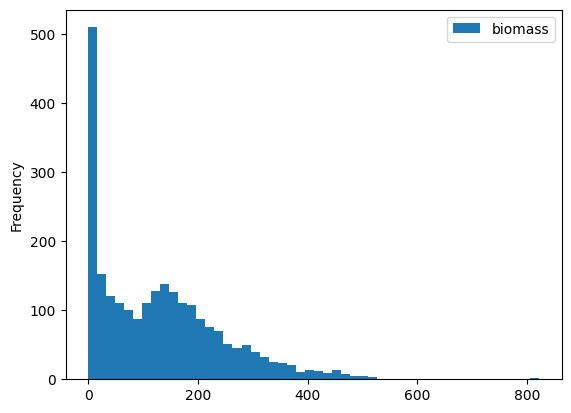

In [ ]:
forecast_df.plot(kind="hist",y="biomass",bins=50)

In [ ]:
final_raf_index,final_depot_index=run_optimization(dist_mat,forecast_df,index_thresh=200,raf_thresh=500,min_depot=15,max_depot=16,N_raf=3,max_iter=1,dlong=0.05,dlat=0.05,n=1,ignore=32000)

status: 1, Optimal
objective: 63127.312036170915
status: 1, Optimal
objective: 43144.31555271134
best run has cost of  43144.31555271246


In [ ]:
raf_index=[985, 1292, 1861]
depot_index=  [989, 925, 985, 1038, 1039, 1176, 1177, 1292, 1359, 1424, 1809, 1751, 1860, 1861, 1862]


model=create_biomass_mat_lp_with_adjust(depot_index,raf_index,forecast,dist_mat)
biomass_mat,pellet_mat,adjust=get_matrices_from_lp(model,len(depot_index),len(raf_index))
forecast_new=adjust.flatten()+forecast.copy().flatten()

costs=get_cost(depot_index,raf_index,biomass_mat,dist_mat,pellet_mat,forecast_new,adjust)

df=create_submission_file(forecast_new,forecast_new,depot_index,raf_index,biomass_mat,biomass_mat,pellet_mat,pellet_mat)
df.to_csv("/content/final_submission.csv",index=False)


status: 1, Optimal
objective: 32004.389019188708


In [ ]:
print(costs)

(0.030000000060681487, 32004.359019190433, 32004.389019190494)


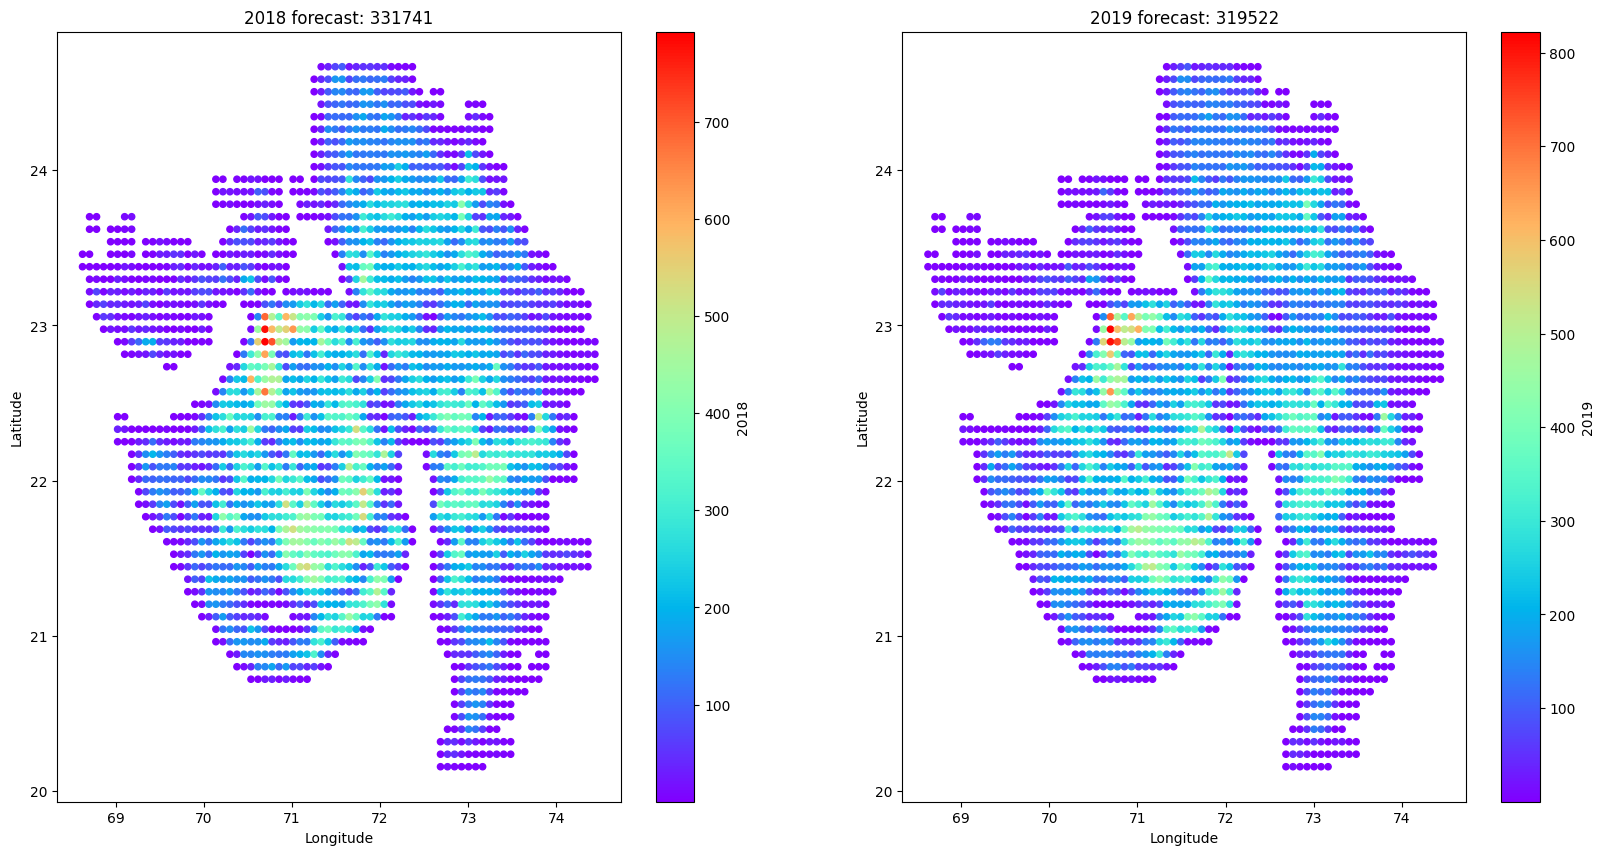

In [ ]:
y1_2018,y2_2019= generate_predictions(pipeline,df_final,"final_submission.csv")